Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.E7KJSH_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.E7KJSH_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - accuracy: 0.4714 - loss: 2.3213 - val_accuracy: 0.7576 - val_loss: 0.8362
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accuracy: 0.8311 - loss: 0.5655 - val_accuracy: 0.7671 - val_loss: 0.7648
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.8923 - loss: 0.3724 - val_accuracy: 0.7828 - val_loss: 0.7233
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 49s 104ms/step - accuracy: 0.9373 - loss: 0.2584 - val_accuracy: 0.7781 - val_loss: 0.7447
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.9579 - loss: 0.1957 - val_accuracy: 0.7826 - val_loss: 0.7298
269/269 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.7875 - loss: 0.7301
Test Loss: 0.7298, Test Accuracy: 0.7826
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


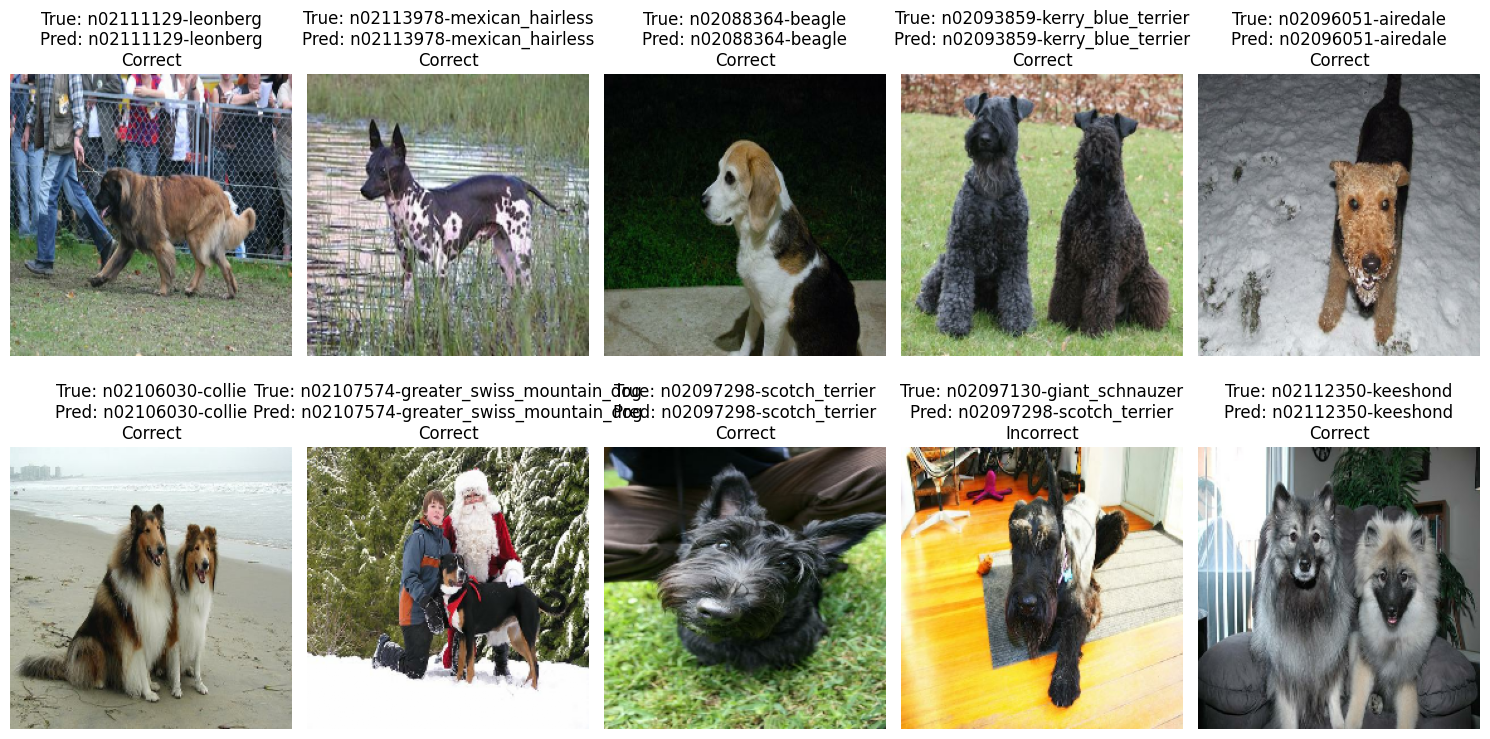

In [1]:
# MobileNetV2 on Stanford Dogs Dataset in Google Colab
# ----------------------------------------------------
# This script loads the Stanford Dogs dataset using TensorFlow Datasets,
# preprocesses it, builds a MobileNetV2-based classifier, trains it,
# and finally displays 10 test images with their true & predicted labels,
# marking each as correct or incorrect.

# 1. Install and import dependencies
!pip install -q tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np

# 2. Load the Stanford Dogs dataset
# We'll use the 'train' and 'test' splits provided by tfds
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features['label'].num_classes
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# 3. Preprocessing function

def preprocess(image, label):
    # Resize image and normalize to [0,1]
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# 4. Prepare datasets: shuffle, batch, prefetch

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# 5. Build the model using MobileNetV2 backbone

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base

# Add classification head
global_avg = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(num_classes, activation='softmax')(global_avg)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Train the model
epochs = 5
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=epochs
)

# 7. Evaluate on test set
loss, accuracy = model.evaluate(ds_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# 8. Collect predictions and display 10 images with correct/incorrect labels

# Get class names
class_names = ds_info.features['label'].names

# Gather a batch of test images and labels
test_images, test_labels = next(iter(ds_test))
preds = model.predict(test_images)
pred_labels = np.argmax(preds, axis=1)

# Determine correctness
correctness = pred_labels == test_labels.numpy()

# Select 10 examples (mix of right/wrong)
indices = np.arange(len(test_images))
# Shuffle indices for randomness
np.random.shuffle(indices)

# Plot first 10
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[idx])
    true_name = class_names[test_labels[idx]]
    pred_name = class_names[pred_labels[idx]]
    status = 'Correct' if correctness[idx] else 'Incorrect'
    plt.title(f"True: {true_name}\nPred: {pred_name}\n{status}")
    plt.axis('off')
plt.tight_layout()
plt.show()
